# Analysing hotel bookings, demand and factors affecting cancelations.

**Team Members:**
Zizheng Gao,
Menghe Liu (Crystal),
Eunjin Jeong (Jenny),
Qianru Ai,
Ta-Wei Wang (David),
Aash Gohil

## Project Proposal:
- To analyse existing hotel bookings, intrinsic difference's between the hotels, understanding the demographic data, and also the sources of demand.

- Additionally, analyse and visualise relationships between the independent variables (like demographic data, lead time, change in booking, deposit paid, booking type etc.) and the probability of cancelation.
 
- If possible, To try and predict using multivariate logistic regression or other ML Models, the probability of cancellation 

**Data Source:** “Hotel Booking Demand Dataset”, Data in Brief Journal Vol 22, Feb 2019 (https://www.kaggle.com/jessemostipak/hotel-booking-demand) </br> "Portugal National Holidays Dataset", timeanddate.com (https://timeanddate.com/holidays/portugal/)

## Introduction and motivation
Hotel's are a tough business to be in. In addition to internal factors like overbookings, underbookings etc, external factors like natural disaster's and especially covid also impact hotels.

That's why now more than ever, its important for hotels to leverage analytics to enable proactive decision making. For the data for the two hotels in Portugal; by analyzing various factors pertaining to demography, hotel types, demands, and cancellations; we would like to dive into the data, ask the right questions, provide data driven insights and recomendations based on our analysis.

## Content
· About the Data</br>
· Demographic Analysis</br>
· Hotel Analysis</br>
· Demand Analysis</br>
· Cancellation Analysis</br>
· BigQuery ML</br>
· Report Summary</br>
· Recommendations</br>
· Limitations</br>
· Link to Dashboard

## About the Data

This data describes hotel demand data for 2 hotels based in Portugal. One of the hotels is a resort hotel and the other is a city hotel. The datasets cointains 32 variables and 119k rows. Each observation/row represents a hotel booking, the data ranges from between the 1st of July of 2015 and the 31st of August 2017

In [5]:
%%bigquery
Select * from `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset` LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.12rows/s]


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Arrival_month_num
0,City Hotel,1,26,2017,January,1,1,1,0,1,...,9,NULL,0,Transient,128.0,0,2,Canceled,2016-12-17,1
1,City Hotel,1,26,2017,January,1,1,2,2,2,...,9,NULL,0,Transient,103.7,0,0,Canceled,2016-12-17,1
2,Resort Hotel,1,42,2017,January,1,2,1,0,2,...,242,NULL,0,Transient,42.0,0,0,Canceled,2016-12-17,1
3,Resort Hotel,1,42,2017,January,1,2,1,0,2,...,242,NULL,0,Transient,42.0,0,0,Canceled,2016-12-17,1
4,City Hotel,1,43,2017,January,1,5,1,3,2,...,9,NULL,0,Transient,74.8,0,0,Canceled,2016-12-19,1


Since both the hotels are based in Portugal and majority of the visitors are also from Portugal, Only Portugese holiday data was scraped from the website timeanddate.com, for the years 2015, 2016 and 2017 corresponding to dataset.

In [18]:
%%bigquery
SELECT * FROM `ba775-project-t-2-b-1.holidays.portugal_holiday` limit 5;

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.36rows/s]


,ds_holidays,holiday,country,code
0,2015-05-01,Labor day,Portugal,PRT
1,2016-05-01,Labor day,Portugal,PRT
2,2017-05-01,Labor day,Portugal,PRT
3,2015-04-03,Good Friday,Portugal,PRT
4,2016-03-25,Good Friday,Portugal,PRT


## 1. Demographic Analysis

### 1.1 Which country do most vistors come from?

Majoritiy of the vistors come from Portugal, which counts for 40.7% of the total visitors. This makes sense since both the hotels are based in Portugal.

In [7]:
%%bigquery
select country, count(*) as booing_num, round(count(*)*100/(select count(*) from `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`),2)
as percentage_of_total from `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`
group by country
order by percentage_of_total desc
limit 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.81rows/s]


,country,booing_num,percentage_of_total
0,PRT,48590,40.70
1,GBR,12129,10.16
2,FRA,10415,8.72
3,ESP,8568,7.18
4,DEU,7287,6.10


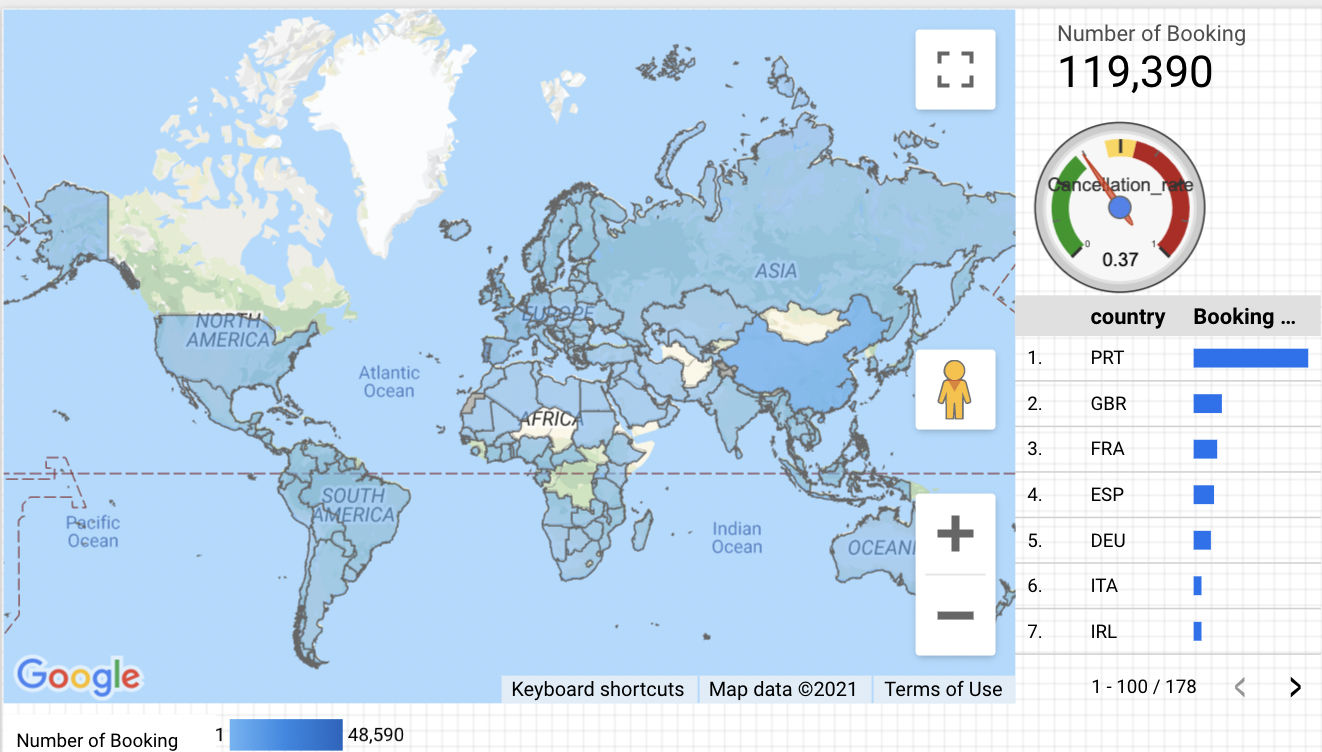

### 1.2 What is the most common vistors' group size

68% of the bookings are made by a group of two adults, and more than 90% of the bookings are made by groups without kids.

In [9]:
%%bigquery
SELECT distinct concat(adults,' adults, ',children+babies,' children') as type, count(hotel) as num,
round(count(hotel)*100/(select count(*) from `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`),2) as percentage_of_total
FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`
group by type
order by num DESC
limit 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.26rows/s]


,type,num,percentage_of_total
0,"2 adults, 0 children",81560,68.31
1,"1 adults, 0 children",22577,18.91
2,"3 adults, 0 children",5666,4.75
3,"2 adults, 1 children",4658,3.90
4,"2 adults, 2 children",3369,2.82


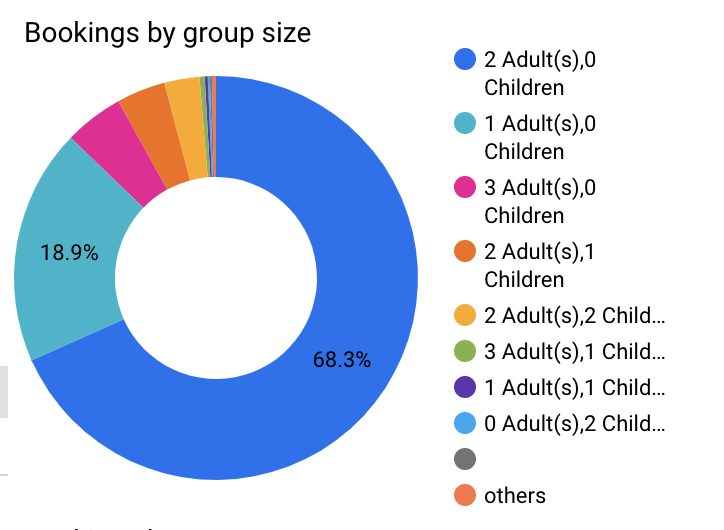

### 1.3 Bookings made by First time customers vs Repeat customers

Most of the bookings are made by first-time guests, and only 3.19% of the bookings are made by repeated guests.

In [46]:
%%bigquery
SELECT case when is_repeated_guest = 0 then 'first-time_guest' else 'repeat_guest' end as guest
,count(*) as guest_num, round(count(*)*100/(select count(*) from `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`),2)
as percentage_of_total FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset` 
group by 1
order by percentage_of_total DESC

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.08rows/s]


,guest,guest_num,percentage_of_total
0,first-time_guest,115580,96.81
1,repeat_guest,3810,3.19


### 1.4 Bookings made by Customer Type

We can observe the highest booking are made by the customer type transient, which refers to booking which arn't part of a group or contract, and not associated with other bookings.

In [43]:
%%bigquery
SELECT customer_type
,count(*) as guest_num, round(count(*)*100/(select count(*) from `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`),2)
as percentage_of_total FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset` 
group by customer_type
order by percentage_of_total DESC

Downloading: 100%|██████████| 4/4 [00:01<00:00,  2.75rows/s]


,customer_type,guest_num,percentage_of_total
0,Transient,89613,75.06
1,Transient-Party,25124,21.04
2,Contract,4076,3.41
3,Group,577,0.48


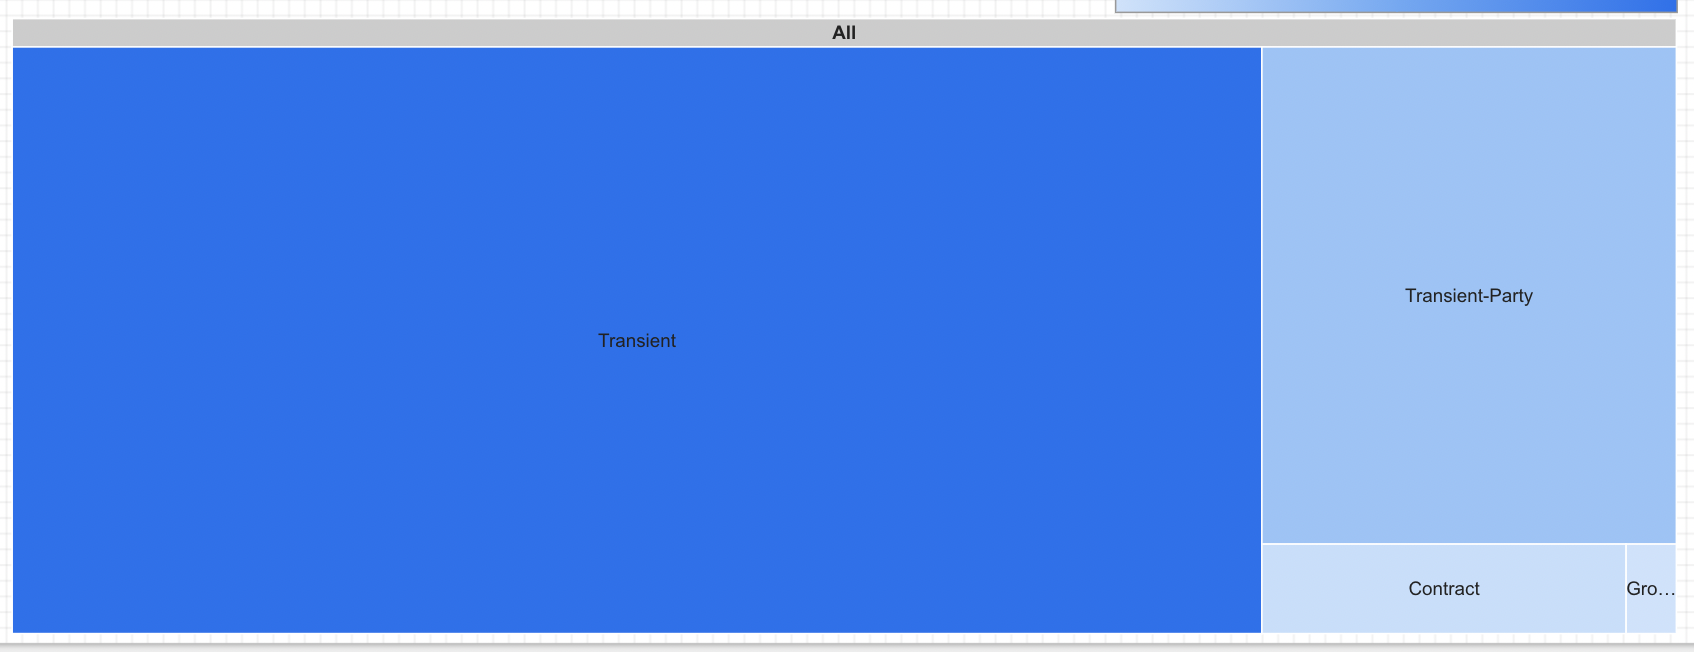

## 2. Hotel Analysis

### 2.1 Average wait time for each hotel and its impact

The average waiting days to get a room are longer for city hotels than resort hotels. The average waiting days for get a room in city hotels is about 3 days, compared to 0.5 days for resort hotels.

This can impact cancellation, with
City hotel bookings being more likely to be cancelled, since 41.73% of the times a reservation of a city hotel is canceled, and only 27.76% of the times a resort hotel is canceled by guests.

In [23]:
%%bigquery
SELECT hotel, AVG(days_in_waiting_list) AS avg_waiting_days,
ROUND(sum(is_canceled)*100/count(is_canceled),2) AS cancellation_rate
FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`
GROUP BY hotel

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.45rows/s]


,hotel,avg_waiting_days,cancellation_rate
0,City Hotel,3.226774,41.73
1,Resort Hotel,0.527758,27.76


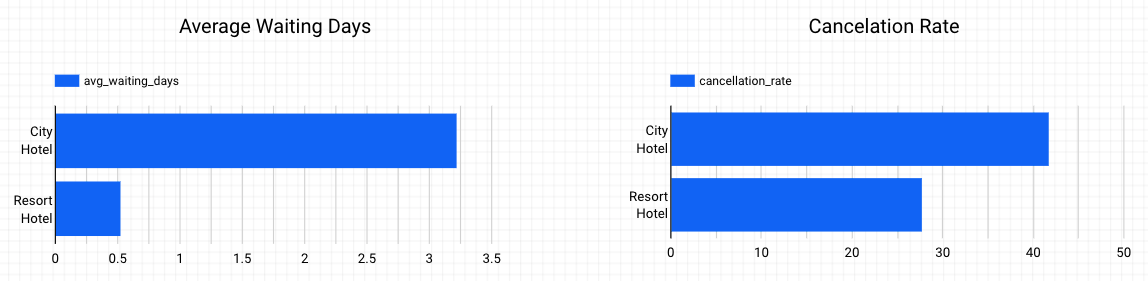

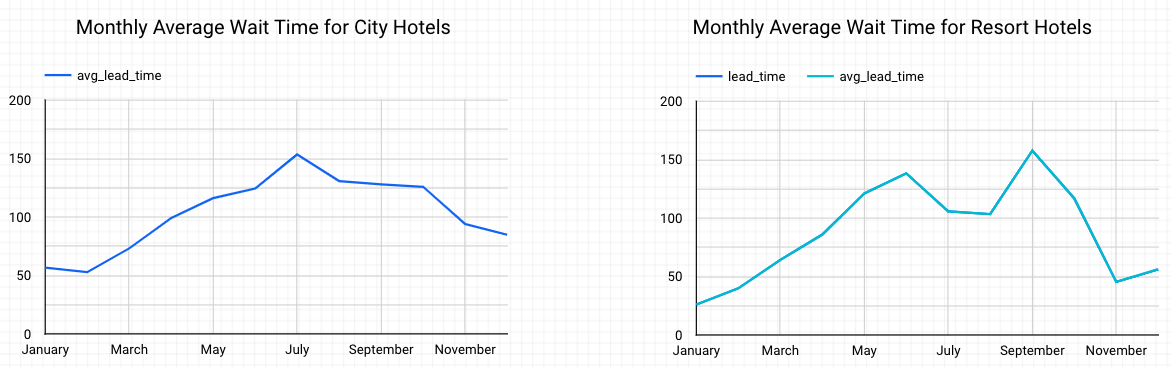

### 2.2 Average days spent and money spent in 2 types of hotel

On average, guest spend close to a day longer at the resort hotel than the city hotel. However Guests spend more per day during their stay at the city hotel than at resport hotel by 15 euro

In [55]:
%%bigquery
select hotel, round(avg(stays_in_weekend_nights),2) Avg_weekend_nights
, round(avg(stays_in_week_nights),2) Avg__weekday_nights
, round(avg(stays_in_week_nights + stays_in_weekend_nights),2) Avg_ttl_nights
, round(avg(adr),2) Avg_Daily_spend_during_stay
from `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset` 
where is_canceled != 1 group by 1

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.34rows/s]


,hotel,Avg_weekend_nights,Avg__weekday_nights,Avg_ttl_nights,Avg_Daily_spend_during_stay
0,Resort Hotel,1.13,3.01,4.14,90.79
1,City Hotel,0.80,2.12,2.92,105.75


### 2.3 Which type of hotel is more popular among guests with children and babies?

For families with kids and babies, resort hotels are more popular than city hotels.

Although there are more guests with kids stayed in city hotels, this type of guest actually prefers staying in resort hotels. Because the total number of reservations is higher for city hotels than resort hotels, the absolute percentage for families with kids staying in resort hotel among total reservations in resort hotels is higher than that in city hotels. Moreover, among all families with kids or babies, 59.03% of them chose to stay in resort hotels, and 40.97% of them stayed in city hotels. In conclusion, resort hotels are prefered by families with kids and babies.

In [15]:
%%bigquery
with main as 
(SELECT *, round(Guest_with_kids*100/Total_Bookings,2) as Absolute_pop_percent
FROM (
SELECT hotel, Count(if(children != 0 or babies !=0, True, Null)) as Guest_with_kids, count(*) AS Total_Bookings
FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset` group by 1
))

select *, round(Absolute_pop_percent*100/(select sum(Absolute_pop_percent) from main),2) as Relative_Popularity_for_guest_w_kids
from main;

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.27rows/s]


,hotel,Guest_with_kids,Total_Bookings,Absolute_pop_percent,Relative_Popularity_for_guest_w_kids
0,City Hotel,5403,79330,6.81,40.97
1,Resort Hotel,3929,40060,9.81,59.03


### 2.4 Which type of hotels is the more popular among guests without children?

For guests without children, city hotels are more popular than resort hotels, but the difference in popularity in this case is not significant.

Among all the reservations in city hotels, 93.19% of guests stayed in the hotel without kids or babies. Among all the reservations in resort hotels, 90.19% of guests stayed in the hotel without kids or babies. Moreover, among all guests stayed in hotels without kids, 50.82% of them chose to stay in city hotels, and 49.18% of them stayed in resort hotels.

In [17]:
%%bigquery
with main2 as
(SELECT *, round(Guest_without_kids*100/Total_Bookings,2) as Absolute_pop_percent_no_kids
FROM (
SELECT hotel, Count(if(children = 0 and babies =0, True, Null)) as Guest_without_kids, count(*) AS Total_Bookings
FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset` group by 1
))
select *, round(Absolute_pop_percent_no_kids*100/(select sum(Absolute_pop_percent_no_kids) from main2),2)as Relative_Popularity_for_guest_no_kids
from main2;

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.37rows/s]


,hotel,Guest_without_kids,Total_Bookings,Absolute_pop_percent_no_kids,Relative_Popularity_for_guest_no_kids
0,City Hotel,73927,79330,93.19,50.82
1,Resort Hotel,36131,40060,90.19,49.18


## 3. Demand Analysis

### 3.1 What type of booking channel do guests prefer the most?

The result shows that Online TA (Online Travel Agent) is the most preferred booking channel by guests accounting for close to 47% of the bookings, followed by Offline TA/TO (Offline Travel Agent/ Tour Operator) accounting for roughly 20% of bookings.

In addition, hotels earned the largest revenue through Online TA, accounting for 56%, followed by Offline TA accounting for 19%.

However, in terms of revenue per booking, Online TA, Direct ranked first, second respectively. Complementary channel earned the lowest revenue per booking.

In [30]:
%%bigquery
SELECT market_segment, count(*) as num_bookings, round(count(*)*100/(select count(*) from `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`),2) 
AS percent_bookings, 
sum(adr*(stays_in_week_nights + stays_in_weekend_nights)) total_revenue,
round(sum(adr*(stays_in_week_nights + stays_in_weekend_nights))*100
/(select sum(adr*(stays_in_week_nights + stays_in_weekend_nights)) from `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`),2)  percent_revenue,
sum(adr*(stays_in_week_nights + stays_in_weekend_nights))/count(*) as revenue_per_booking
FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`
GROUP BY market_segment
ORDER BY 2 DESC
LIMIT 6;

Downloading: 100%|██████████| 6/6 [00:01<00:00,  3.88rows/s]


,market_segment,num_bookings,percent_bookings,total_revenue,percent_revenue,revenue_per_booking
0,Online TA,56477,47.30,23942047.53,56.04,423.925625
1,Offline TA/TO,24219,20.29,8151912.73,19.08,336.591632
2,Groups,19811,16.59,4669636.74,10.93,235.709290
3,Direct,12606,10.56,5093028.39,11.92,404.016214
4,Corporate,5295,4.44,774295.26,1.81,146.231399
5,Complementary,743,0.62,5082.52,0.01,6.840538


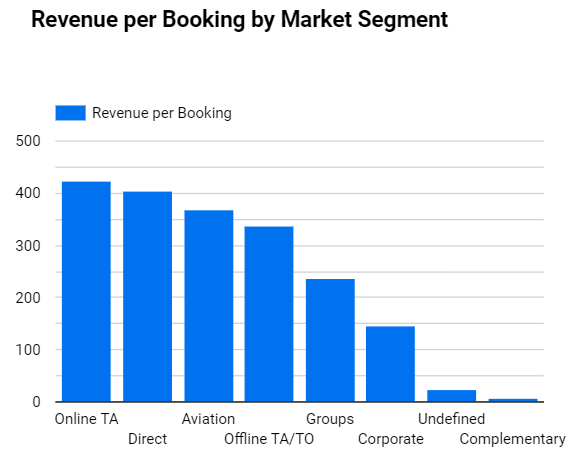

### 3.2 What type of meal plans do guests generally go for?

The result reports that guests generally go for breakfast-only plan, with 77 percent opting for it.

In [24]:
%%bigquery
SELECT case when meal = 'BB' then 'Only Breakfast'
when meal = 'HB' then 'Breakfast + Additional Meal'
when meal = 'FB' then 'Breakfast, Lunch and Dinner'
when meal = 'SC' or meal = 'Undefined' then 'No meals' end as Meal_type
, count(*) AS num_booking
,round(count(*)*100/(select count(*) from `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`),2) 
AS percent_of_booking
FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`
GROUP BY meal_type
ORDER BY num_booking DESC

#Undefined/SC – no meal package;
#BB – Bed & Breakfast;
#HB – Half board (breakfast and one other meal – usually dinner);
#FB – Full board (breakfast, lunch and dinner)

Downloading: 100%|██████████| 4/4 [00:01<00:00,  2.42rows/s]


,Meal_type,num_booking,percent_of_booking
0,Only Breakfast,92310,77.32
1,Breakfast + Additional Meal,14463,12.11
2,No meals,11819,9.90
3,"Breakfast, Lunch and Dinner",798,0.67


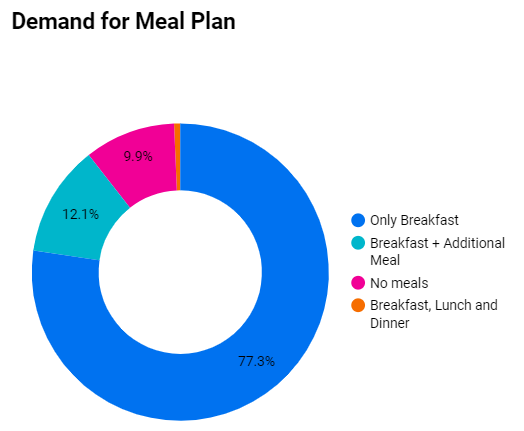

### 3.3 Which month do guests spend the longest time in a hotel?

On average, Guest have longer stays in July and August spending around 2.25 and 2.12 days, respectively.

In [39]:
%%bigquery
SELECT arrival_date_month, round(avg(stays_in_weekend_nights + stays_in_weekend_nights),2) as avg_nights_per_stay

FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`
GROUP BY 1 order by 2 desc

Downloading: 100%|██████████| 12/12 [00:01<00:00,  8.47rows/s]


,arrival_date_month,avg_nights_per_stay
0,July,2.24
1,August,2.12
2,April,1.90
3,September,1.88
4,June,1.84
5,October,1.79
6,May,1.74
7,December,1.73
8,March,1.72
9,February,1.71


### 3.4 Which months have the most reservations? and what is its average booking lead time?

Guests visit hotels the most in the summer season(June, July, August) and the least in the winter season(December, January, February).

Likewise, hotels gain the largest revenue per booking in the summer season.

On average guests tend to prepare their visits early for summer, fall season and late for winter, spring.

In [20]:
%%bigquery
SELECT arrival_date_month, count(*) AS num_bookings, round(avg(lead_time),2) lead_time,
sum(adr*(stays_in_week_nights + stays_in_weekend_nights)) abs_revenue,
round(sum(adr*(stays_in_week_nights + stays_in_weekend_nights))*100
/(select sum(adr*(stays_in_week_nights + stays_in_weekend_nights)) from `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`),2)  percent_revenue,
sum(adr*(stays_in_week_nights + stays_in_weekend_nights))/count(*) as revenue_per_booking
FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`
GROUP BY arrival_date_month
ORDER BY 2 DESC

Downloading: 100%|██████████| 12/12 [00:01<00:00,  7.30rows/s]


,arrival_date_month,num_bookings,lead_time,abs_revenue,revenue_percent,revenue_per_booking
0,August,13877,121.14,7944717.43,18.60,572.509723
1,July,12661,136.32,6587713.64,15.42,520.315428
2,May,11791,117.65,4108125.90,9.62,348.412001
3,October,11160,122.99,3009549.50,7.04,269.672894
4,April,11089,94.82,3710466.14,8.68,334.607822
5,June,10939,128.25,4499387.28,10.53,411.316142
6,September,10508,136.68,3731917.18,8.74,355.150093
7,March,9794,70.12,2639221.09,6.18,269.473258
8,February,8068,47.86,1818972.70,4.26,225.455218
9,November,6794,76.58,1600156.54,3.75,235.524954


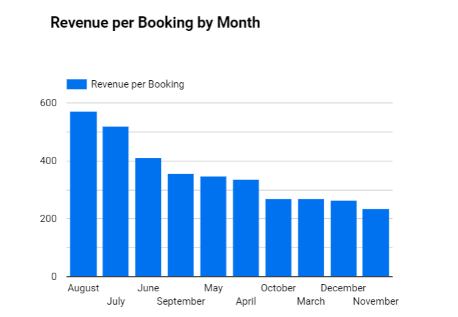

### 3.5 When do hotels have the most reservations by date?

From the result the maximum number of bookings were for 5th Dec, 2015, which coresponded with the holiday "Zweiter Advent" in Portugal.
Even though on average, December has one of the lowest number of bookings. 

In [13]:
%%bigquery
SELECT PARSE_DATE("%Y/%B/%d", concat(arrival_date_year,"/",arrival_date_month,"/",arrival_date_day_of_month)) date,
count(*) as reservation_num
from `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`
group by 1
order by 2 desc limit 5;

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.43rows/s]


,date,reservation_num
0,2015-12-05,448
1,2016-11-07,366
2,2015-10-16,356
3,2016-10-13,344
4,2015-09-18,340


### 3.6 Analyzing with Portugal Holidays Dataset.

On analzying the hotel booking dataset with the portugal national holidays dataset, we see on average, the revenue per booking is higher by 20 Euro's. Additionally the number of bookings per day is higher for Portugal holidays by 13 bookings.

In [16]:
%%bigquery
with hotel_hol as 
( select * from (select *, PARSE_DATE("%Y/%B/%d", concat(arrival_date_year,"/",arrival_date_month,"/",arrival_date_day_of_month)) as date_of_arrival
from `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`) htl_dt
left join
 `ba775-project-t-2-b-1.holidays.portugal_holiday` hol_dt
on htl_dt.date_of_arrival =  hol_dt.ds_holidays)

select case when ds_holidays is not null then 'Portugal_National_Holidays'
when ds_holidays is null then 'No_Holiday' end as Holiday, count(*) as num_booking, 
count(distinct date_of_arrival) distinct_days,
round(count(*)/ count(distinct date_of_arrival),2) Bookings_per_day,
round(sum(adr*(stays_in_week_nights + stays_in_weekend_nights))/count(*),2) as revenue_per_booking
from hotel_hol  group by 1;

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.22rows/s]


,Holiday,num_booking,distinct_days,Bookings_per_day,revenue_per_booking
0,Portugal_National_Holidays,3932,24,163.83,378.21
1,No_Holiday,115458,769,150.14,357.15


## 4. Cancellation Analysis

### 4.1 Impact of lead days on cancelation

We divided the lead time according to several bars, and calculated the cancellation rate for each. Since there are only two orders with lead days greater than 700 days, we think this is not representative. 

In [22]:
%%bigquery
SELECT
CASE
when lead_time=0 then '0'
when lead_time>=1 and lead_time<50 then '1-49'
when lead_time>=50 and lead_time <100 then '50-99'
when lead_time>=100 and lead_time <150 then '100-149'
when lead_time>=150 and lead_time <200 then '150-199'
when lead_time>=200 and lead_time <250 then '200-249'
when lead_time>=250 and lead_time <300 then '250-299'
when lead_time>=300 and lead_time <350 then '300-349'
when lead_time>=350 and lead_time <400 then '350-399'
when lead_time>=400 and lead_time <450 then '400-449'
when lead_time>=450 and lead_time <500 then '450-499'
when lead_time>=500 and lead_time <550 then '500-549'
when lead_time>=550 and lead_time <600 then '550-600'
when lead_time>=600 and lead_time <650 then '600-649'
when lead_time>=650 and lead_time <700 then '650-699'
when lead_time>=700 then '>=700'
end AS lead_time_range, count(*) AS total_frequency,
SUM(is_canceled) AS cancellation_frequency, round(SUM(is_canceled)*100/count(*),2) AS cancellation_rate
FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`
WHERE lead_time IS NOT null
GROUP BY lead_time_range
ORDER BY lead_time_range DESC;

Downloading: 100%|██████████| 15/15 [00:01<00:00,  9.70rows/s]


,lead_time_range,total_frequency,cancellation_frequency,cancellation_rate
0,>=700,2,0,0.00
1,600-649,145,145,100.00
2,550-600,119,119,100.00
3,500-549,215,148,68.84
4,50-99,21402,8596,40.16
5,450-499,636,437,68.71
6,400-449,998,659,66.03
7,350-399,1809,1200,66.33
8,300-349,4056,2772,68.34
9,250-299,5692,3398,59.70


The result shows that on average, the earlier a guest make's a booking the higher the cancellation rate is, with the cancellation rates of 600-649 and 500-600 lead days being highest, of 100%, and cancellation rate of lead time = 0 is the lowest, of 6.78%.</br>
In general,  the longer the lead days, the higher the cancellation rate.

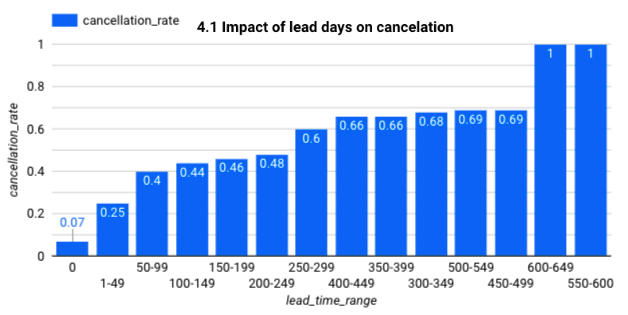

### 4.2 Are guests who make more changes less likely or more likely to cancel？

Usually, when a guest makes change, it would increase the cost of the hotel. That is why we wanted to investigate the relationship between changes the guests made and the cancellation rate, because if the guest who made several changes finally cancel his/her order, it would cause more loss of the hotel.

From the results, we can see that guests who make changes in their bookings have a lower cancellation rate than those who do not.

In [47]:
%%bigquery
SELECT case when booking_changes = 0 then 'No' else 'Yes' end as change_in_booking
, COUNT(*) AS total_frequency, SUM(is_canceled) AS cancellation_frequency, 
round(SUM(is_canceled)*100/count(is_canceled),2) AS cancellation_rate
FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`
GROUP BY change_in_booking
ORDER BY cancellation_rate DESC

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.27rows/s]


,change_in_booking,total_frequency,cancellation_frequency,cancellation_rate
0,No,101314,41391,40.85
1,Yes,18076,2833,15.67


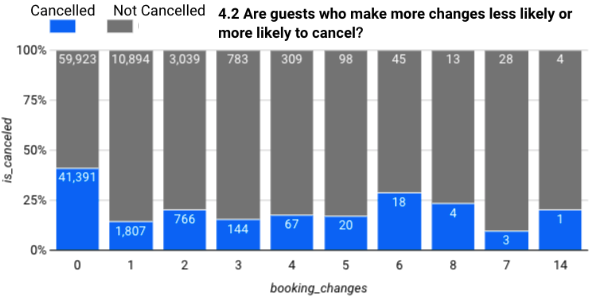

### 4.3 Cancellation rate by different hotel

From the result, can be concluded that City Hotel experienced a higher cancellation rate.

In [50]:
%%bigquery
SELECT hotel, COUNT(*) AS total_frequency, SUM(is_canceled) AS cancellation_frequency,
round(SUM(is_canceled)*100/count(is_canceled),2) AS cancellation_rate
FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`
GROUP BY hotel
ORDER BY hotel;

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.45rows/s]


,hotel,total_frequency,cancellation_frequency,cancellation_rate
0,City Hotel,79330,33102,41.73
1,Resort Hotel,40060,11122,27.76


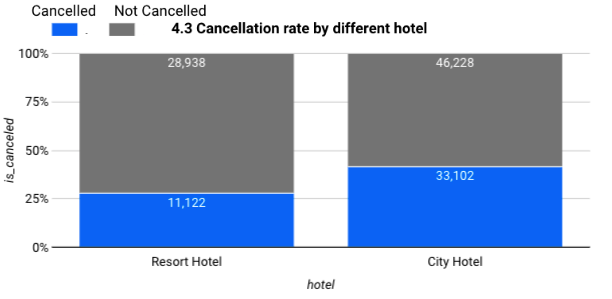

As these hotels are anonymous, we couldn’t find the exact policies of cancellation of the two hotels. We speculate that several reasons could lead to this result:</br>
1. Resort Hotel may have a **stricter cancellation policy**. For example, customers must cancel two days in advance, or for discounted orders, cancellation is prohibited.</br>
2. Customers may have **different characteristics** for the two types of hotels. <br>
   **For resort hotels**, most of the customers are there for vacation. Therefore, the hotel is a part of the whole vacation plan. If a hotel order needs to be cancelled, it generally means that the entire vacation plan is cancelled, which has a lower frequency and the customers would try to avoid this situation.</br>
   **For city hotels**, the client's plans appear more casual and there are more hotels available for substitution

### 4.4 Cancellation rate by market segment

Market segments reflect the source of sales. Therefore, investigating the relationship between market segments and cancellation rate is necessary.

It can be seen that orders of Complementary have the lowest cancellation rate, while orders from Groups have the highest cancellation rate. The Direct segment is also performing well (2nd lowest cancellation rate) and is a more controllable market segment for hotels. Thus, the hotels should focus on building their own distribution channel.

In [3]:
%%bigquery
SELECT market_segment, count(*) AS total_frequency, SUM(is_canceled) AS cancellation_frequency, 
round(SUM(is_canceled)*100/COUNT(*),2) AS cancellation_rate
FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`
GROUP BY market_segment
ORDER BY cancellation_rate

Downloading: 100%|██████████| 8/8 [00:01<00:00,  5.30rows/s]


,market_segment,total_frequency,cancellation_frequency,cancellation_rate
0,Complementary,743,97,13.06
1,Direct,12606,1934,15.34
2,Corporate,5295,992,18.73
3,Aviation,237,52,21.94
4,Offline TA/TO,24219,8311,34.32
5,Online TA,56477,20739,36.72
6,Groups,19811,12097,61.06
7,Undefined,2,2,100.00


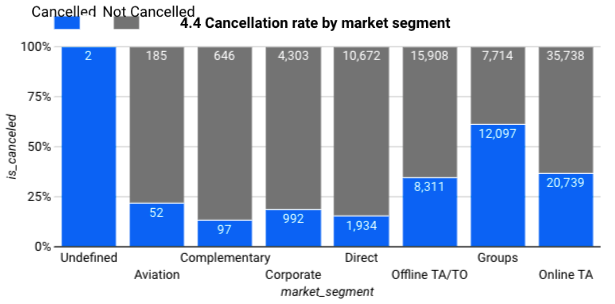

### 4.5 Cancellation rate by deposit type

The deposit is a means for the hotel to reduce the loss caused by the cancellation of the customer. But does it increase the probability of cancellation to some extent?

We should notice that the author's definitions of non-refund and refundable are a bit different from what we generally think of as definitions. In this dataset, **non-refund** means **the payment occurred before checking in was equal or exceeded the total cost of stay**, and **Refundable** means **the payment occurred before checking in was between zero and the total cost of stay**. 

We can see that the harshest, non-refundable deposit type actually has the highest cancellation rate. Meanwhile, refundable deposits have the lowest cancellation rates.

In [52]:
%%bigquery
SELECT deposit_type, count(*) AS total_frequency, SUM(is_canceled) AS cancellation_frequency, 
round(SUM(is_canceled)*100/COUNT(*),2) AS cancellation_rate
FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`
GROUP BY deposit_type

Downloading: 100%|██████████| 3/3 [00:01<00:00,  1.87rows/s]


,deposit_type,total_frequency,cancellation_frequency,cancellation_rate
0,No Deposit,104641,29694,28.38
1,Non Refund,14587,14494,99.36
2,Refundable,162,36,22.22


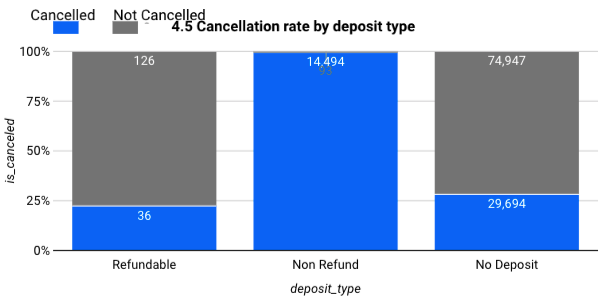

Further, we explored the deposit types and corresponding cancellation rates for each of the two hotels. 

In [15]:
%%bigquery
SELECT hotel, deposit_type, count(*) AS total_frequency, SUM(is_canceled) AS cancellation_frequency, 
round(SUM(is_canceled)*100/COUNT(*),2) AS cancellation_rate
FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`
GROUP BY hotel, deposit_type
ORDER BY hotel

Downloading: 100%|██████████| 6/6 [00:01<00:00,  3.67rows/s]


,hotel,deposit_type,total_frequency,cancellation_frequency,cancellation_rate
0,City Hotel,No Deposit,66442,20244,30.47
1,City Hotel,Non Refund,12868,12844,99.81
2,City Hotel,Refundable,20,14,70.00
3,Resort Hotel,No Deposit,38199,9450,24.74
4,Resort Hotel,Non Refund,1719,1650,95.99
5,Resort Hotel,Refundable,142,22,15.49


We can see that both hotels have the most orders under No Deposit. The difference, however, is that for City Hotel, no deposit type has the lowest cancellation rate, while for Resort Hotel, the refundable type corresponds to the lowest cancellation rate.

The extremely high cancellation rate of Non Refund seems counterintuitive. We found the answer in the author's papaer *Big Data in Hotel Revenue Management: Exploring Cancellation Drivers to Gain Insights Into Booking Cancellation Behavior*, in which he explained:</br>
"These bookings (the cancelled Non Refund) are usually made through OTA using false or invalid credit card details. These bookings are issued as support for requests for visas to enter the country (a hotel booking is mandatory for applying for a Portuguese entry visa). After failing to charge the customer’s credit card, the hotel identifies these bookings as “fake” and contacts the customer; however, during the time required to verify these bookings, they contribute negatively to demand forecast and demand-management decisions."

While cancellations of non-refundable orders are not subjective cancellations by the customer, they should still be avoided. Considering the combined cancellation rate and number of orders, both hotels should not set a deposit.

### 4.6 Cancellation rate by customer type

It can be concluded that the Transient customers have the highest cancellation rate, while the Group customers have the lowest cancellation rates.

In [54]:
%%bigquery
SELECT customer_type, count(*) AS total_frequency, SUM(is_canceled) AS cancellation_frequency, 
round(SUM(is_canceled)*100/COUNT(*),2) AS cancellation_rate
FROM `ba775-project-t-2-b-1.hotel_booking.hotel_booking_dataset`
GROUP BY customer_type
ORDER BY SUM(is_canceled)/COUNT(*) DESC, SUM(is_canceled) DESC

Downloading: 100%|██████████| 4/4 [00:01<00:00,  2.90rows/s]


,customer_type,total_frequency,cancellation_frequency,cancellation_rate
0,Transient,89613,36514,40.75
1,Contract,4076,1262,30.96
2,Transient-Party,25124,6389,25.43
3,Group,577,59,10.23


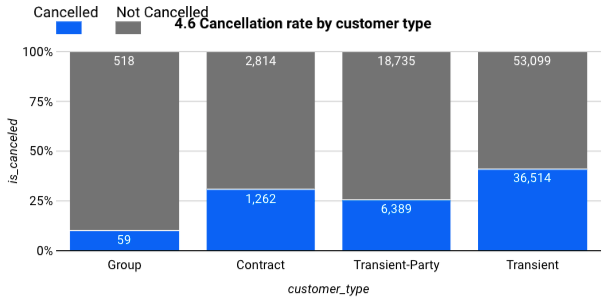

## 5. BigQuery ML


### 5.1 Model training
Train the model with 2015-2016 data which counts for 75% of the dataset.
We included several features like customer_type and deposit_type which we found that may have significant impact on the cancelation rate based on analysis from previous parts. 

In [39]:
%%bigquery
CREATE or replace model `hotel_booking.hotel_booking_model_TRAIN`
options(model_type='logistic_reg', input_label_cols= ['is_canceled'])
as
SELECT is_canceled, lead_time,adr,
Case when deposit_type = 'Non Refund' then 1
Else 0 end as if_non_refund,
Case when hotel = 'Resort Hotel' then 0
Else 1 end as hotel_type,
stays_in_weekend_nights, stays_in_week_nights,
Case when agent is null Then 0
ELSE 1 end as Booked_through_agent,
Case when company is null Then 0
ELSE 1 end as Booked_through_company,
case when (children + babies) = 0 then 0
else 1 end as group_w_kid, booking_changes,
case when customer_type  = 'Transient' then 1
else 0 end as if_non_group_transient,
is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, total_of_special_requests, required_car_parking_spaces
FROM `hotel_booking.hotel_booking_dataset`
where arrival_date_year in (2015,2016)

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1838.53query/s]                        


""


### 5.2 Model evaluating
We than evaluate the classification model with the remaining 25% of the dataset 

The model has a percision rate of 79.47%, which means nearly 80% of predicted positives that were actual positives. A 74.54% of accuracy rate stands for the fraction of predictions given the correct label. The model does a decent job on predicting the likelihood of cancelation of a booking, but there are spaces for improvement on the model. 

In [40]:
%%bigquery
Select * from ML.EVALUATE(MODEL `hotel_booking.hotel_booking_model_TRAIN`, (
SELECT is_canceled, lead_time,adr,
Case when deposit_type = 'Non Refund' then 1
Else 0 end as if_non_refund,
Case when hotel = 'Resort Hotel' then 0
Else 1 end as hotel_type,
stays_in_weekend_nights, stays_in_week_nights,
Case when agent is null Then 0
ELSE 1 end as Booked_through_agent,
Case when company is null Then 0
ELSE 1 end as Booked_through_company,
case when (children + babies) = 0 then 0
else 1 end as group_w_kid, booking_changes,
case when customer_type  = 'Transient' then 1
else 0 end as if_non_group_transient,
is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, total_of_special_requests, required_car_parking_spaces
FROM `hotel_booking.hotel_booking_dataset`
where arrival_date_year in (2017)
))

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.52s/rows]


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.794748,0.461353,0.745447,0.583806,0.493877,0.801221


### 5.3 Confusion matrix
The confusion matrix can show that the model performs better on predicting true negatives.

In [41]:
%%bigquery
Select * from ML.CONFUSION_MATRIX(MODEL `hotel_booking.hotel_booking_model_TRAIN`, (
SELECT is_canceled, lead_time,adr,
Case when deposit_type = 'Non Refund' then 1
Else 0 end as if_non_refund,
Case when hotel = 'Resort Hotel' then 0
Else 1 end as hotel_type,
stays_in_weekend_nights, stays_in_week_nights,
Case when agent is null Then 0
ELSE 1 end as Booked_through_agent,
Case when company is null Then 0
ELSE 1 end as Booked_through_company,
case when (children + babies) = 0 then 0
else 1 end as group_w_kid, booking_changes,
case when customer_type  = 'Transient' then 1
else 0 end as if_non_group_transient,
is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, total_of_special_requests, required_car_parking_spaces
FROM `hotel_booking.hotel_booking_dataset`
where arrival_date_year in (2017)
))

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.39rows/s]


,expected_label,_0,_1
0,0,23066,1876
1,1,8481,7264


## Report Summary

Our report is divided into four sections. In **Demographic Analysis**, we found out that most visitors are from Portugal, without kids, and transient customers. In **Hotel Analysis**, the report shows that guests wait less to get a room, cancel more, stay longer and spend less money in a resort hotel. The resort hotel is also preferred by guests with kids.  In **Demand Analysis**, the report shows that online travel agents are predominantly the biggest booking channel. The direct channel is the fourth-largest but it returns the second largest revenue per booking. For the summer season, guests tend to stay longer, plan travel in advance, and visit hotels the most.  In **Cancellation Analysis**, we found that the longer the lead days, the higher the cancellation rate, while the changes made by customers could decrease the cancellation rate. Also, different hotels, market segments, deposit types and customer types have differences in cancellation rates.

Combining the results of these four components, we made several recommendations for hotels to boost demand and reduce cancellation rates.

## Recommendations

- One suggestion is to expand the Direct channel. It gives the second largest revenue per booking but the proportion is still low. In addition, the cancellation rate of direct channel is the second smallest. For example,if hotels don't have a website they can open their own website and give customers incentive when they reserve directly.

- While demand analysis reports that guests tend to plan visiting hotels in advance for the peak season, too early reservations result in cancellations. For example, lead time of more than 550 days cause 100% of cancellations. Therefore, hotels can limit reservations up to 300 days before arrival; Lead time of more than 300 days accounts for only 6%, but the cancellation rate goes over 66%. This policy also can reserve rooms for authentic customers.

- To decrease the cancellation rate, hotels could open up as many customization options as possible for customers to make more changes, after weighing costs..

## Limitations

- Hotels in this dataset are anonymous. 

- Revenue per stay is known but Cost per stay is unknown, so we couldn’t calculate net profit.

- Total rooms available are not provided in the dataset and thus we do not know the occupancy rate

- The ML model does not perform well on predicting true positives


## Link to Dashboard

https://datastudio.google.com/reporting/0e296b41-cc9d-4a65-a37d-b8a73df4a1b3/page/p_cl1mgqgzmc

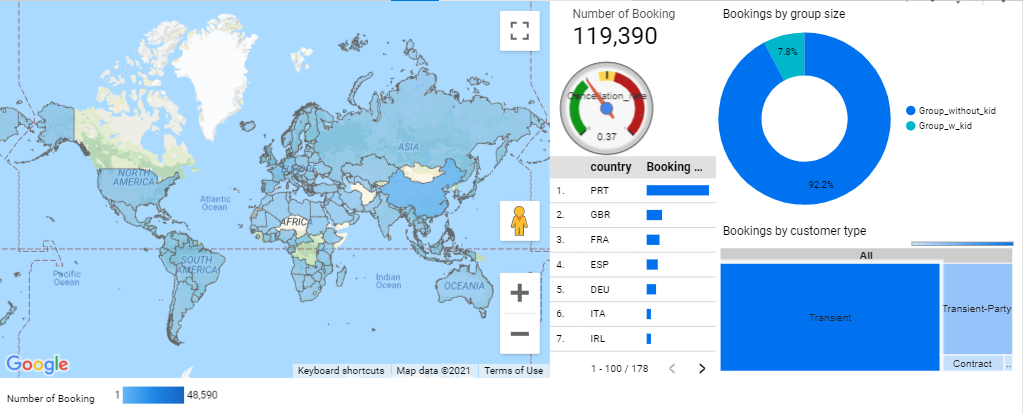

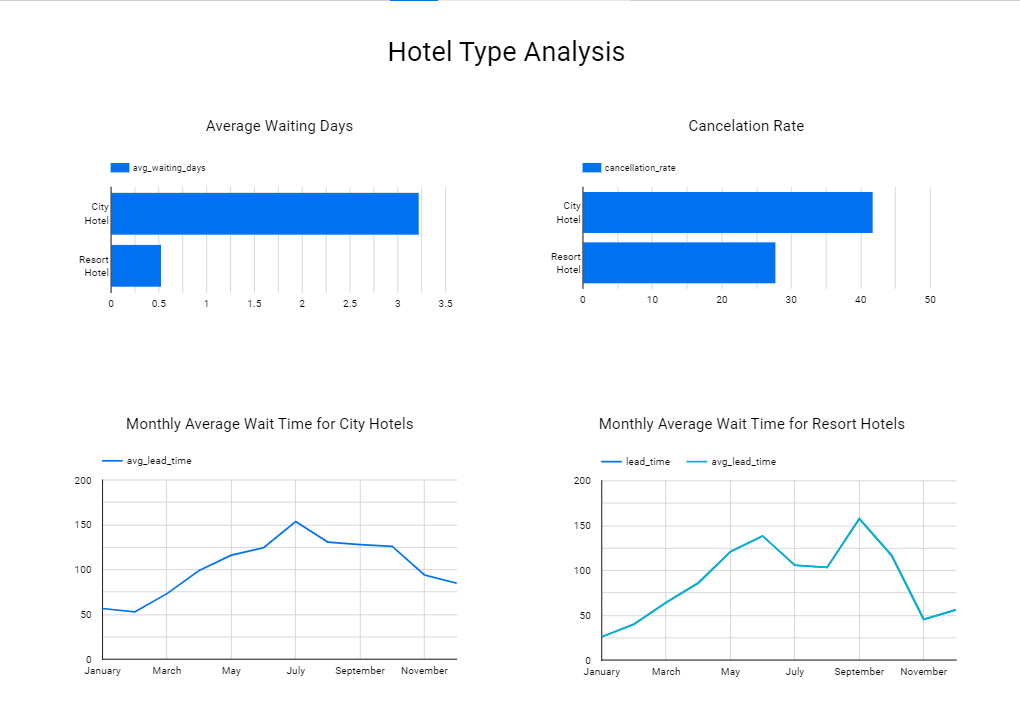

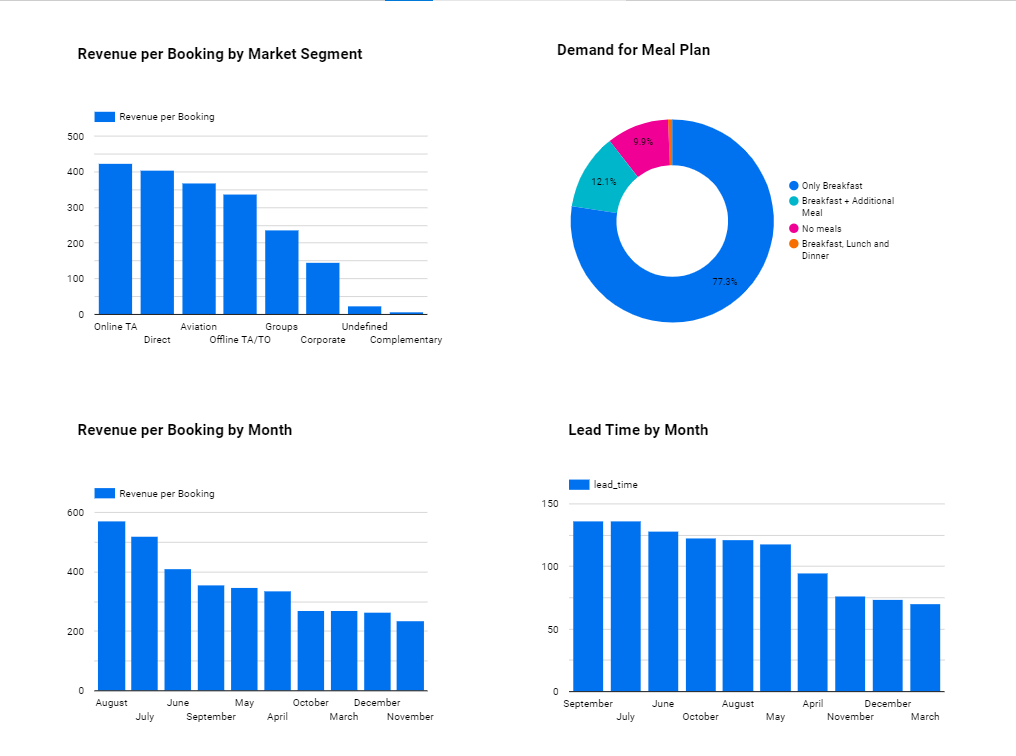

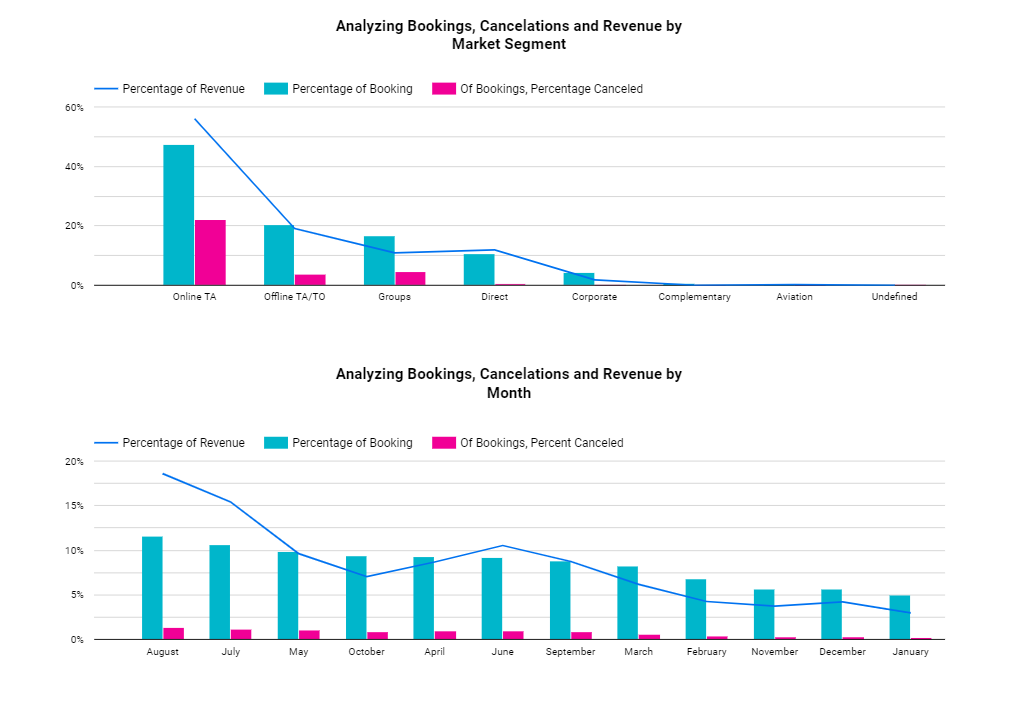

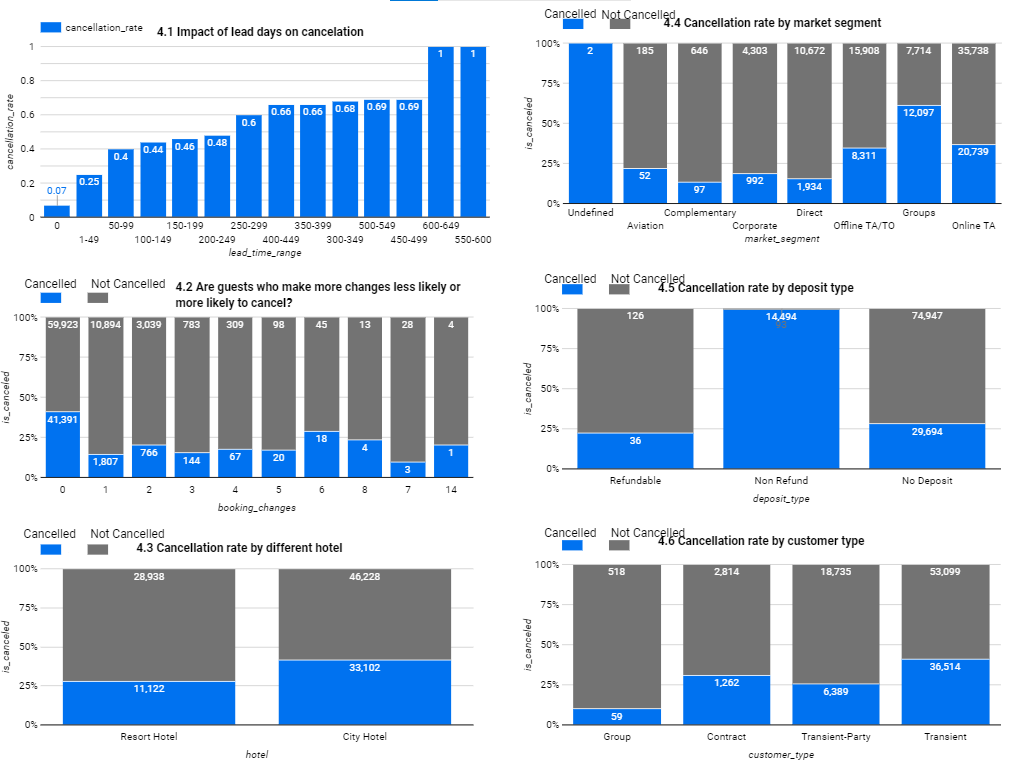